In [1]:
from ioMicro import *

In [164]:
??dec.get_inters

Signature: dec.get_inters(dinstance_th=2, enforce_color=False)
Source:   
    def get_inters(self,dinstance_th=2,enforce_color=False):
        """Get an initial intersection of points and save in self.res"""
        res =[]
        if enforce_color:
            icols = self.XH[:,-2].astype(int)
            XH = self.XH
            for icol in tqdm(np.unique(icols)):
                inds = np.where(icols==icol)[0]
                Xs = XH[inds,:3]
                Ts = cKDTree(Xs)
                res_ = Ts.query_ball_tree(Ts,dinstance_th)
                res += [inds[r] for r in res_]
        else:
            XH = self.XH
            Xs = XH[:,:3]
            Ts = cKDTree(Xs)
            res = Ts.query_ball_tree(Ts,dinstance_th)
        self.res = res
File:      c:\scripts\nmerfish\iomicro.py
Type:      method


In [ ]:
def get_inters(self,dinstance_th=2,enforce_color=False):
        """Get an initial intersection of points and save in self.res"""
        res =[]
        if enforce_color:
            icols = self.XH[:,-2].astype(int)
            XH = self.XH
            for icol in tqdm(np.unique(icols)):
                inds = np.where(icols==icol)[0]
                Xs = XH[inds,:3]
                Ts = cKDTree(Xs)
                res_ = Ts.query_ball_tree(Ts,dinstance_th)
                res += [inds[r] for r in res_]
        else:
            XH = self.XH
            Xs = XH[:,:3]
            Ts = cKDTree(Xs)
            res = Ts.query_ball_tree(Ts,dinstance_th)
        self.res = res

In [293]:
XH=dec.XH[:,:3]
icols = dec.XH[:,-2].astype(int)
icol=0
Xs = XH[icols==icol,:3]
tree = cKDTree(Xs)


In [ ]:
tree.query_ball_tree(tree,2,)

In [ ]:
tree.query(

In [2]:
from worker_Scope1__EmbryoPlate12Low import *
fov,set_ = 'Conv_zscan__059','_D16'
dec = decoder_simple(save_folder,fov=fov,set_=set_)
dec.get_XH(fov,set_,ncols=3)#number of colors match 
dec.XH = dec.XH[dec.XH[:,-4]>0.25] ### keep the spots that are correlated with the expected PSF for 60X
dec.load_library(library_file,nblanks=-1)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:58<00:00,  3.24s/it]


In [3]:
dec.res = np.load('temp_res.pkl',allow_pickle=True)

In [ ]:
def get_icodes(dec,nmin_bits=4,method = 'top4',redo=False,norm_brightness=None,nbits=48,is_unique=True):
    
    ### unfold molecules
    import time
    start = time.time()
    res = dec.res
    print("Filtering to have nmin_bits number of mol/cluster")
    res = [r for r in res if len(r)>=nmin_bits]
    print("Calculating lengths of clusters...")
    lens = np.array(list(map(len,res)))
    Mlen = np.max(lens)
    print("Unfolding indexes...")
    res_unfolder = np.concatenate(res)

    print("Calculating indexes within cluster...")
    #res_is = np.array([i for l in lens for i in range(l)]) ### could be sped up
    res_is = np.tile(np.arange(Mlen), len(lens))
    res_is = res_is[res_is < np.repeat(lens, Mlen)]
    print("Calculating index of molecule...")
    ires = np.repeat(np.arange(len(lens)), lens)
    #r0 = np.array([r[0] for r in res for r_ in r])
    print("Calculating index of first molecule...")
    r0i = np.concatenate([[0],np.cumsum(lens)])[:-1]
    r0 = res_unfolder[np.repeat(r0i, lens)]
    print("Total time unfolded molecules:",time.time()-start)
    
    
    import torch
    ires = torch.from_numpy(ires.astype(np.int64))
    res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
    res_is = torch.from_numpy(res_is.astype(np.int64))

Filtering to have nmin_bits number of mol/cluster
Unfolding indexes...
Calculating lengths of clusters...
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 53.27383875846863


In [270]:
#np.savez_compressed('res_unfolder.npz',res_unfolder=res_unfolder,lens=lens)

In [3]:
res_unfolder = np.load('res_unfolder.npz')['res_unfolder']
lens = np.load('res_unfolder.npz')['lens']

In [5]:
import time
start = time.time()
Mlen = np.max(lens)
print("Calculating indexes within cluster...")
#res_is = np.array([i for l in lens for i in range(l)]) ### could be sped up
res_is = np.tile(np.arange(Mlen), len(lens))
res_is = res_is[res_is < np.repeat(lens, Mlen)]
print("Calculating index of molecule...")
ires = np.repeat(np.arange(len(lens)), lens)
#r0 = np.array([r[0] for r in res for r_ in r])
print("Calculating index of first molecule...")
r0i = np.concatenate([[0],np.cumsum(lens)])[:-1]
r0 = res_unfolder[np.repeat(r0i, lens)]
print("Total time unfolded molecules:",time.time()-start)


import torch
ires = torch.from_numpy(ires.astype(np.int64))
res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
res_is = torch.from_numpy(res_is.astype(np.int64))

Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 16.608062267303467


In [7]:
### get score for brightness 
def get_scoresH():
    H = torch.from_numpy(dec.XH[:,-3])
    Hlog = H#np.log(H)
    mnH = Hlog.mean()
    stdH = Hlog.std()
    distribution = torch.distributions.Normal(mnH, stdH)
    scoreH = distribution.cdf(Hlog)
    return scoreH[res_unfolder]
### get score for inter-distance between molecules
def get_scoresD():
    X = dec.XH[:,:3]
    XT = torch.from_numpy(X)
    XD = XT[res_unfolder]-XT[r0]
    meanD = -torch.mean(torch.abs(XD),axis=-1)
    distribution = torch.distributions.Normal(meanD.mean(), meanD.std())
    scoreD = distribution.cdf(meanD)
    return scoreD
def get_combined_scores():
    scoreH = get_scoresH()
    scoreD = get_scoresD()
    ### combine scores. Note this score is for all the molecules un-ravelled from their clusters
    scoreF = scoreD*scoreH
    return scoreF
import time
start = time.time()
print("Computing score...")
if False:
    scoreF = get_combined_scores()
else:
    scoreF = torch.from_numpy(dec.XH[:,-3])[res_unfolder]
print("Total time computing score:",time.time()-start)

### organize molecules in blocks for each cluster
def get_asort_scores():
    val = torch.max(scoreF)+2
    scoreClu = torch.zeros([len(lens),Mlen],dtype=torch.float64)+val
    scoreClu[ires,res_is]=scoreF
    asort = scoreClu.argsort(-1)
    scoreClu = torch.gather(scoreClu,dim=-1,index=asort)
    scoresF2 = scoreClu[scoreClu<val-1]
    return asort,scoresF2
def get_reorder(x,val=-1):
    if type(x) is not torch.Tensor:
        x = torch.from_numpy(np.array(x))
    xClu = torch.zeros([len(lens),Mlen],dtype=x.dtype)+val
    xClu[ires,res_is] = x
    xClu = torch.gather(xClu,dim=-1,index=asort)
    xf = xClu[xClu>val]
    return xf

import time
start = time.time()
print("Computing sorting...")
asort,scoresF2 = get_asort_scores()
res_unfolder2 = get_reorder(res_unfolder,val=-1)
del asort
del scoreF
print("Total time sorting molecules by score:",time.time()-start)

Computing score...
Total time computing score: 1.1732234954833984
Computing sorting...
Total time sorting molecules by score: 37.62052607536316


In [11]:
nbits = 48
delta_bits=4
nmin_bits = 4
import time
start = time.time()
print("Finding best bits per molecules...")

Rs = dec.XH[:,-1].astype(np.int64)
Rs = torch.from_numpy(Rs)
Rs_U = Rs[res_unfolder2]

score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
score_bits[ires,Rs_U]=scoresF2
argsort_bits = torch.argsort(score_bits,dim=-1,descending=True)[:,:(nmin_bits+delta_bits)]
score_bits = score_bits.gather(1,argsort_bits)
indexMols = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
indexMols[ires,Rs_U]=res_unfolder2
indexMols = indexMols.gather(1,argsort_bits)


indexMols_pm = indexMols[:,:nmin_bits]
keep_pm = torch.all(indexMols_pm>=0,dim=-1)
indexMols = indexMols[keep_pm]
score_bits = score_bits[keep_pm]

indexMols_pm = indexMols[:,:nmin_bits]
score_bits_pm = score_bits[:,:nmin_bits]
codeMols_pm = Rs[indexMols_pm]
codeMols_pm = codeMols_pm.sort(dim=-1)[0]
codeMols = Rs[indexMols]
codeMols[indexMols<0]=-1
print("Total time best bits per molecule:",time.time()-start)

Finding best bits per molecules...
Total time best bits per molecule: 30.36252212524414


In [27]:
torch.unique(torch.sum(indexMols==-1,dim=-1),return_counts=True)

(tensor([0, 1, 2, 3, 4]),
 tensor([20617675,  7411775,  8365639,  8905771,  8909711]))

In [29]:
codes__ = dec.codes__
codes_lib = torch.from_numpy(np.array(codes__).astype(np.int64)).sort(dim=-1)[0]

In [31]:
ign = list(dec.gns_names).index('Dcx')

In [55]:
torch.sum(torch.sum(torch.isin(codeMols[:,:6],codes_lib[ign]),dim=-1)==4)

tensor(516537)

In [53]:
codeMols[100]

tensor([15, 42,  0,  6, -1, -1, -1, -1])

In [157]:
#list(zip(scoresF2[:50].numpy(),ires[:50].numpy()))

In [158]:
#scoresF2

In [58]:
score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
score_bits[ires,Rs_U]=scoresF2

In [64]:
score_bits_1d = score_bits[1000]

In [73]:
codes_lib_01 = torch.zeros([len(codes_lib),nbits],dtype=score_bits.dtype)
for icd,cd in enumerate(codes_lib):
    codes_lib_01[icd,cd]=1

In [92]:
batch = 10000
icodes_best = torch.zeros(len(score_bits),dtype=torch.int64)
for i in tqdm(range((len(score_bits)//batch)+1)):
    score_bits_ = score_bits[i*batch:(i+1)*batch]
    if len(score_bits_)>0:
        icodes_best[i*batch:(i+1)*batch] = torch.argmax(torch.matmul(score_bits_,codes_lib_01.T),dim=-1)
        
keep_all_bits = torch.all(score_bits.gather(1,codes_lib[icodes_best])>=0,-1)
icodes_best_ = icodes_best[keep_all_bits]
indexMols_ = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
indexMols_[ires,Rs_U]=res_unfolder2
indexMols_ = indexMols_[keep_all_bits]
indexMols_ = indexMols_.gather(1,codes_lib[icodes_best_])
XH = torch.from_numpy(dec.XH)
XH_pruned = XH[indexMols_]
icodesN=icodes_best_

100%|██████████████████████████████████████████████████████████████████████████████| 5939/5939 [02:12<00:00, 44.99it/s]


In [ ]:
dec.XH_pruned = XH_pruned.numpy()
dec.icodesN = icodesN.numpy()

In [166]:
scoresRefT = np.load('scoresRefT.pkl',allow_pickle=True)

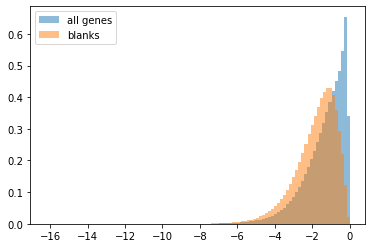

In [173]:
dec.ncols = len(scoresRefT)
get_score_withRef(dec,scoresRefT,plt_val=True)

In [175]:
dec.scoreA.shape

(45618178,)

In [190]:
np.sum(dec.scoreA[dec.icodesN>418]>-1.)/np.sum(dec.scoreA[dec.icodesN<418]>-1.)

0.11240052842980029

In [194]:
np.mean(dec.scoreA>-1.5)

0.6165342026592996

In [154]:
X = torch.from_numpy(dec.XH[:,:3])
X_gn = X[indexMols_[icodes_best_==ign]].mean(dim=1)

In [211]:
keep = (dec.icodesN==ign)&(dec.scoreA>-1.)
X_gn = np.mean(dec.XH_pruned[keep],axis=1)


In [212]:
gene = 'Dcx'
ncols = 3
fl_raw = r'\\192.168.0.6\bbfishjoy4\CGBB_embryo_4_28_2023\H101_MER_D16\Conv_zscan__059.zarr'
im = read_im(fl_raw)[1]
import napari
new_drift = [ -0.96623084,167.84815618,-97.83324511]
v = napari.view_image(im,translate=new_drift)
v.add_points(X_gn[:,:3],size=1,face_color='r',name='dot')

<Points layer 'dot' at 0x1ede0ba86a0>

In [210]:
dec.XH_pruned[keep].shape

(148534, 4, 10)

In [201]:
ibad = 83539
dec.XH_pruned[keep][ibad,:,-3]

array([ 6206.0390625 , 12862.95703125, 14123.83203125,  4949.59960938])

In [220]:
np.median(dec.XH_pruned[keep][:,:,-3])

26079.6796875

In [ ]:
dec.XH_pruned[keep][:,:,-3]

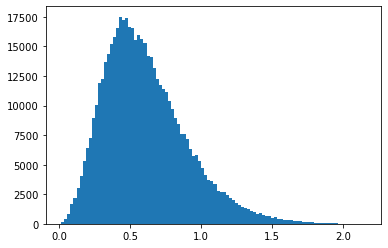

In [230]:
d = np.linalg.norm(X_-X_.mean(1)[:,np.newaxis],axis=-1)
d_ = d.ravel()
plt.hist(d_,bins=100);

In [239]:
X_ = dec.XH_pruned[:,:,:3]
d = np.linalg.norm(X_-X_.mean(1)[:,np.newaxis],axis=-1)
h = np.log(dec.XH_pruned[:,:,-3])

In [286]:
kp = np.all((h>np.log(10000))&(d<1.5),axis=-1)

In [287]:
keep = (dec.icodesN[kp]==ign)
X_gn = np.mean(dec.XH_pruned[kp][keep],axis=1)

gene = 'Dcx'
ncols = 3
fl_raw = r'\\192.168.0.6\bbfishjoy4\CGBB_embryo_4_28_2023\H101_MER_D16\Conv_zscan__059.zarr'
im = read_im(fl_raw)[1]
import napari
new_drift = [ -0.96623084,167.84815618,-97.83324511]
v = napari.view_image(im,translate=new_drift)
v.add_points(X_gn[:,:3],size=10,face_color='r',name='dot')

<Points layer 'dot' at 0x1edb4daa430>

In [280]:
np.sum(dec.icodesN[dec.scoreA>-1]==ign)

130413

In [277]:
np.sum(dec.icodesN[kp]>418)/np.sum(dec.icodesN[kp]<418)

0.0872545826053481

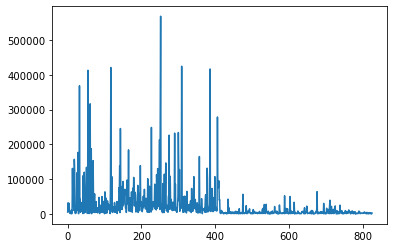

In [289]:
kp2 = dec.scoreA>-1
icds,ncds = np.unique(dec.icodesN[kp2],return_counts=True)
plt.plot(icds,ncds)

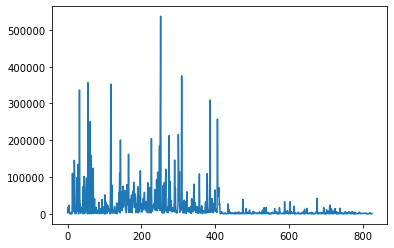

In [288]:
icds,ncds = np.unique(dec.icodesN[kp],return_counts=True)
plt.plot(icds,ncds)

In [256]:
sc = -(d-np.mean(d))/np.std(d)+(h-np.mean(h))/np.std(h)

In [259]:
np.exp(np.median(h))

12302.621093749993

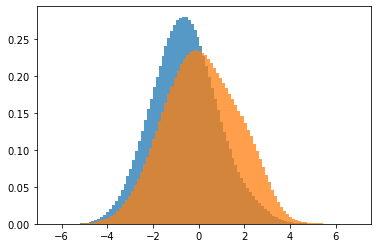

In [257]:
d_ = sc[dec.icodesN>418].ravel()
plt.hist(d_,bins=100,alpha=0.75,density=True);
d_ = sc[dec.icodesN<418].ravel()
plt.hist(d_,bins=100,alpha=0.75,density=True);

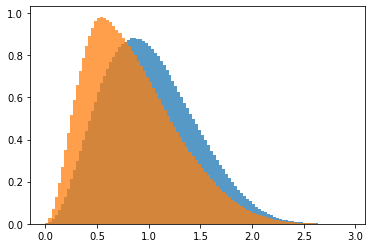

In [245]:
d_ = d[dec.icodesN>418].ravel()
plt.hist(d_,bins=100,alpha=0.75,density=True);
d_ = d[dec.icodesN<418].ravel()
plt.hist(d_,bins=100,alpha=0.75,density=True);

In [236]:
np.mean(np.all(d<1,axis=-1))

0.6851080797159792

In [223]:
X_ = dec.XH_pruned[keep][:,:,:3]
np.linalg.norm(X_-X_.mean(1)[:,np.newaxis],axis=-1)

array([[0.88347621, 0.78184001, 0.7143499 , 0.84504186],
       [0.13091948, 0.35429881, 0.57155271, 0.59253241],
       [1.2818397 , 0.08295747, 0.69957421, 0.68465444],
       ...,
       [0.57117804, 0.3994264 , 0.5301576 , 0.20142333],
       [0.53562271, 1.11777971, 0.37296548, 0.95860678],
       [0.58112025, 0.47233702, 0.52874228, 0.26553206]])

In [208]:
X_ = dec.XH_pruned[keep][ibad,:,:3]
np.linalg.norm(X_-X_.mean(0)[np.newaxis],axis=-1)

array([1.57015412, 0.54671869, 1.33094981, 0.15643507])

In [200]:
dec.scoreA[keep][83539]

-1.2334052943409244

In [150]:
icds,ncts = torch.unique(icodes_best_,return_counts=True)

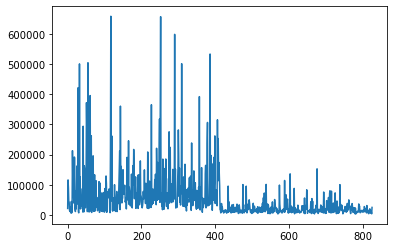

In [151]:
plt.plot(icds,ncts)

In [113]:
X = dec.XH[:,:3]
XT = torch.from_numpy(X)
XD = XT[res_unfolder2]-XT[r0]

In [127]:
dist_cutoff=2
bad = torch.any(XD>dist_cutoff*0.75,dim=-1)

In [129]:
score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
score_bits[ires,Rs_U]=scoresF2

In [134]:
score_bits[ires[bad],Rs_U[bad]]=-1

In [136]:
keep_all_bits = torch.sum(score_bits>-1,dim=-1)>=nmin_bits

tensor([0, 1, 2,  ..., 3, 2, 3])

In [132]:
bad.shape,Rs_U.shape

(torch.Size([508868978]), torch.Size([508868978]))

In [115]:
res_unfolder2

tensor([    4616,       98,      108,  ..., 62956314, 74348867, 68626675])

In [ ]:
get

In [112]:
icodes_best_

tensor([ 10,  10,  10,  ..., 368, 459, 449])

In [105]:
icds,cts = torch.unique(icodes_best_,return_counts=True)

In [111]:
torch.sum(ign==icodes_best_)

tensor(173791)

In [90]:
score_bits[59387835:59387835+5]

tensor([], size=(0, 48), dtype=torch.float64)

In [81]:
len(score_bits)

59387835

In [168]:
#ign = list(dec.gns_names).index('Dcx')
#torch.sum(torch.all(codeMols==codes_lib[ign],-1))

In [186]:
torch.cuda.is_available()

False

In [184]:
codeMols.to("cuda")

AssertionError: Torch not compiled with CUDA enabled

In [170]:
print("Comparing with library and asigning code")
icodesN = torch.zeros(len(codeMols),dtype=torch.int64)-1
for icd,cd in enumerate(tqdm(codes_lib)):
    icodesN[torch.all(codeMols==cd,dim=-1)]=icd
keep = icodesN>=0
icodesN = icodesN[keep]
codeMols = codeMols[keep]
indexMols = indexMols[keep]
score_bits2 = score_bits2[keep]

Comparing with library and asigning code


100%|████████████████████████████████████████████████████████████████████████████████| 826/826 [01:16<00:00, 10.84it/s]


In [171]:
XH_pruned = dec.XH[indexMols]

In [182]:

tensor = codeMols
element_size = tensor.element_size()
total_elements = tensor.numel()
total_memory = element_size * total_elements
total_memory/10**9

1.031398784

In [173]:
icodesN = icodesN.numpy()

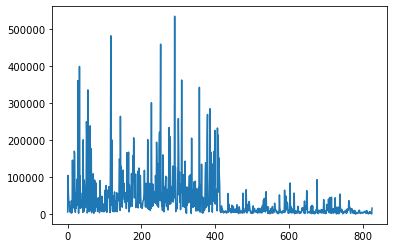

In [175]:
icds,ncds = np.unique(icodesN,return_counts=True)
plt.plot(icds,ncds)

In [141]:
len(XH_pruned)

29765969

In [121]:
torch.unique(codeMols[icodesN>=0],return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 tensor([4285487, 7049217, 6512077, 2963878, 5597069, 4597060, 1431857, 3305203,
         3961414, 4480797, 6120474, 5220369, 3247549, 4997002, 3452300, 3747574,
         4461417, 3440828, 3721501, 4350027, 3224991, 2416704, 3317475, 2639123,
         2574455, 3306639, 2274190, 2029836, 1615330,  495084,  496620,  894836,
          279073,  535722,  923882,  206614,  393499,  662383,  221253,  324099,
          631727,  300825,  205273,  776094,  314535,  283009,  537841,  239664]))

In [128]:
ign = dec.gns_names.index('Dcx')
torch.sum(icodesN==ign)

tensor(102916)

In [134]:
XH_ = dec.XH[indexMols[icodesN==ign]]

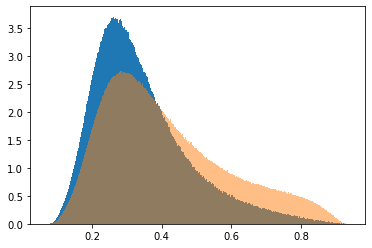

In [114]:
th_gn = [ig for ig,gn in enumerate(dec.gns_names) if 'blank' in gn][0]
score_bad = mean_score_bits[icodesN>=th_gn].numpy()
score_good = mean_score_bits[(icodesN<th_gn)&(icodesN>=0)].numpy()
plt.hist(score_bad,density=True,bins=300);
plt.hist(score_good,density=True,bins=300,alpha=0.5);

In [118]:
np.sum(score_bad>0.5)/np.sum(score_good>0.5)

0.10970105288870848

In [90]:
cds,ncts = torch.unique(icodesN,return_counts=True)

In [101]:
mean_score_bits = score_bits2.mean(dim=-1)

In [103]:
mean_score_bits[:30]

tensor([0.1684, 0.2409, 0.2109, 0.5689, 0.2117, 0.1970, 0.1970, 0.2589, 0.2388,
        0.3806, 0.2876, 0.2566, 0.2785, 0.2490, 0.3205, 0.1899, 0.4704, 0.2474,
        0.1868, 0.3467, 0.2838, 0.3368, 0.2712, 0.5806, 0.2875, 0.4075, 0.3662,
        0.2002, 0.2100, 0.3808], dtype=torch.float64)

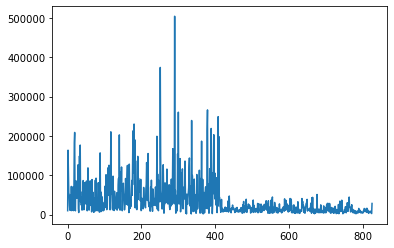

In [91]:
plt.plot(cds[1:].numpy(),ncts[1:].numpy())

In [94]:
np.mean(ncts[1:418].numpy())#/np.mean(ncts[418:].numpy())

58143.529976019185

In [86]:
cd = codes_lib[0]


tensor([False, False, False,  ..., False, False, False])

In [76]:
codes_lib.shape

torch.Size([826, 4])

In [41]:
indexMols[0]

tensor([4616,   -1,   -1,   -1])

In [321]:
scoreF

tensor([0.9557, 0.6709, 0.6141,  ..., 0.0420, 0.0221, 0.3296],
       dtype=torch.float64)

In [311]:
score_bits[100]

tensor([ 0.3589, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.4242, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.5198,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000,  0.9557, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
       dtype=torch.float64)

In [315]:
scoreClu[0]

tensor([0.2049, 0.6141, 0.6709, 0.9557, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000],
       dtype=torch.float64)

In [301]:
score_bits[ires.flip(0),Rs_U.flip(0)]=scoresF2.flip(0)

4

In [291]:
scoreClu[300]

tensor([0.3076, 0.3562, 0.4624, 0.9557, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000],
       dtype=torch.float64)

In [267]:
score_bits[0]

tensor([ 0.2049, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
       dtype=torch.float64)

In [262]:
Rs_U

tensor([ 0,  0,  0,  ..., 41, 47, 35], dtype=torch.int32)

In [187]:
runfT2 = torch.gather(runfT,dim=-1,index=asort)
res_unfolder2 = runfT2[runfT2>=0]

In [191]:
scoreClu = torch.gather(scoreClu,dim=-1,index=asort)


In [192]:
#scoresF2,res_unfolder2

tensor([0.2049, 0.6141, 0.6709,  ..., 0.0420, 0.3296, 0.9557],
       dtype=torch.float64)

In [195]:
scoreF[:10]

tensor([0.9557, 0.6709, 0.6141, 0.2049, 0.9557, 0.5409, 0.8424, 0.6870, 0.9557,
        0.7579], dtype=torch.float64)

In [159]:
distribution = torch.distributions.Normal(meanD.mean(), meanD.std())
scoreD = np.log(distribution.cdf(meanD))

In [158]:
meanD = -torch.mean(torch.abs(XD),axis=-1)

In [152]:
#torch.sort(cdf)

In [135]:
distribution.cdf(torch.from_numpy(np.array([200])))

tensor([1.])

In [105]:
H = torch.from_numpy(dec.XH[:,-3])

In [115]:
Hsc = H[runfT]
Hsc[runfT<0]=0

In [116]:
Hsc

tensor([[ 5183.8594,  5617.3828,  5633.4590,  ...,     0.0000,     0.0000,
             0.0000],
        [ 4697.8125,  3955.2227,  3787.4634,  ...,     0.0000,     0.0000,
             0.0000],
        [ 5164.8750,  4947.2109,  4601.6523,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [ 3790.2949,  4185.7056, 12072.7354,  ...,     0.0000,     0.0000,
             0.0000],
        [ 3992.9795,  4634.2197,  3894.0713,  ...,     0.0000,     0.0000,
             0.0000],
        [ 4954.8989,  5954.0938,  4938.9526,  ...,     0.0000,     0.0000,
             0.0000]], dtype=torch.float64)

In [113]:
Hsc.argsort(-1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\BINTUL~2\AppData\Local\Temp/ipykernel_28112/1965476591.py", line 1, in <module>
    Hsc.argsort(-1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\IPython\core\interactiveshell.py", line 3447, in run_code
    sys.excepthook = old_excepthook
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\BintuLabUser\anaconda3\envs\cellpose\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

TypeError: object of type 'NoneType' has no len()

In [85]:
res_is = np.array([ir for r in tqdm(res) for ir,r_ in enumerate(r)])


 76%|█████████████████████████████████████████████████▊                | 44872458/59387835 [01:15<00:26, 548792.03it/s]

KeyboardInterrupt: 

In [83]:

for ir,r in enumerate(tqdm(res)):
    runfT[ir,:len(r)]=torch.from_numpy(r)

 16%|██████████▉                                                        | 9730429/59387835 [01:04<05:28, 151273.32it/s]


KeyboardInterrupt: 

In [81]:
runfT[ir,:len(r)]=r

TypeError: can't assign a numpy.ndarray to a torch.LongTensor

In [76]:
res_unfolder

array([      98,      108,     4613, ..., 68626675, 74348866, 74348867],
      dtype=int64)

In [70]:
NDim = 100
meanD_ = meanD[:(len(meanD)//NDim)*NDim].reshape([-1,NDim])

In [71]:
meanD_.argsort(dim=-1)

tensor([[ 0, 44, 28,  ..., 84, 30, 39],
        [24, 51, 34,  ..., 14, 66, 13],
        [ 0, 44, 56,  ..., 70, 91, 87],
        ...,
        [16, 74,  4,  ..., 49,  2, 67],
        [12, 47, 28,  ...,  1, 73, 68],
        [34, 88,  6,  ..., 91, 19, 17]])

In [ ]:
[0.231,9,0.3,23232,323]
[1,1,2,2,2,3,3,3]

In [24]:
ires = ires.astype(np.int64)
nbitMax = np.max(bits_unfold)
ires_full=(ires*(nbitMax+1)+bits_unfold)

In [26]:
np.max(ires_full)

2850616079

In [27]:
iresU = np.unique(ires_full)

In [30]:
Brs = dec.XH[:,-3][res_unfolder]

In [31]:
ndimage.maximum(Brs,ires_full,iresU)

array([5633.45898438, 4697.8125    , 5164.875     , ..., 4954.89892578,
       5954.09375   , 5089.21484375])

In [32]:
ires.dtype

dtype('int64')

In [10]:
from scipy import ndimage
ndimage

In [ ]:
r0 = np.array([])

In [ ]:
bits_unfold

In [ ]:
inds_spotsN =  np.zeros([len(res),nbits],dtype=int)-1
inds_spotsN[ires[arg_scores],bits_unfold[arg_scores]]=res_unfolder[arg_scores]